In [118]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

In [119]:
file_path = '/kaggle/input/sms-spam-collection-dataset/spam.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [120]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [121]:
# Dropping the redundent looking collumns (for this project)
to_drop = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
df = df.drop(df[to_drop], axis=1)
df.rename(columns = {"v1":"Label", "v2":"Text"}, inplace = True)
df.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


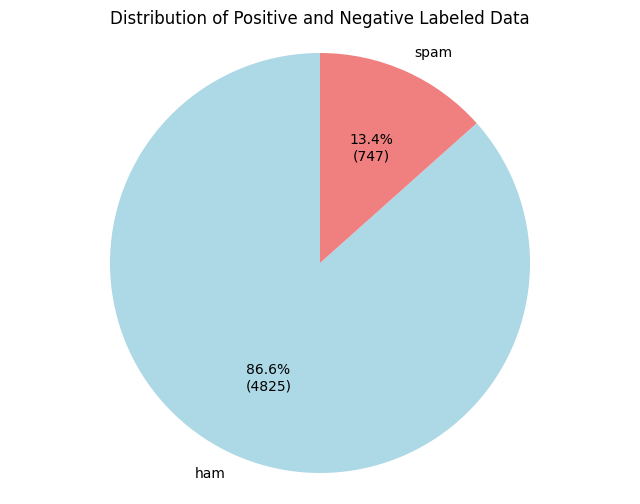

In [122]:
import matplotlib.pyplot as plt

# Assuming df['Label'] contains your labels (positive/negative or 0/1)
label_counts = df['Label'].value_counts()

# Function to display both percentage and count
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return '{:.1f}%\n({:d})'.format(pct, count)
    return my_format

# Plotting a pie chart with light blue and light red, showing both percentage and count
plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_counts.index, autopct=autopct_format(label_counts), startangle=90, colors=['lightblue', 'lightcoral'])
plt.title('Distribution of Positive and Negative Labeled Data')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()


In [123]:
# Check for missing values
df.isnull().sum()

Label    0
Text     0
dtype: int64

In [124]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords if you haven't already
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# LOWER CASING
df['Clean'] = df.apply(lambda row: row['Text'].lower(), axis=1)

# REMOVING @
df['Clean'] = df.apply(lambda row: re.sub(r"@[A-Za-z0-9_]+", "", row['Clean']), axis=1)

# REMOVING #
df['Clean'] = df.apply(lambda row: re.sub(r"#[A-Za-z0-9_]+", "", row['Clean']), axis=1)

# REMOVING LINKS
df['Clean'] = df.apply(lambda row: re.sub(r"www.\S+", "", row['Clean']), axis=1)
df['Clean'] = df.apply(lambda row: re.sub(r"http\S+", "", row['Clean']), axis=1)

# REMOVING SYMBOLS
df['Clean'] = df.apply(lambda row: re.sub(r"[^a-z0-9]", " ", row['Clean']), axis=1)

# REMOVING STOP WORDS
df['Clean'] = df.apply(lambda row: ' '.join([word for word in row['Clean'].split() if word not in stop_words]), axis=1)

# VIEW CLEANED DATA
df = df[['Clean', 'Label']]
df.head(10)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Clean,Label
0,go jurong point crazy available bugis n great ...,ham
1,ok lar joking wif u oni,ham
2,free entry 2 wkly comp win fa cup final tkts 2...,spam
3,u dun say early hor u c already say,ham
4,nah think goes usf lives around though,ham
5,freemsg hey darling 3 week word back like fun ...,spam
6,even brother like speak treat like aids patent,ham
7,per request melle melle oru minnaminunginte nu...,ham
8,winner valued network customer selected receiv...,spam
9,mobile 11 months u r entitled update latest co...,spam


In [125]:
df['Label'] = df['Label'].map({'spam': 1, 'ham': 0})
df.head(10)


,Clean,Label
0,go jurong point crazy available bugis n great ...,0
1,ok lar joking wif u oni,0
2,free entry 2 wkly comp win fa cup final tkts 2...,1
3,u dun say early hor u c already say,0
4,nah think goes usf lives around though,0
5,freemsg hey darling 3 week word back like fun ...,1
6,even brother like speak treat like aids patent,0
7,per request melle melle oru minnaminunginte nu...,0
8,winner valued network customer selected receiv...,1
9,mobile 11 months u r entitled update latest co...,1


In [126]:
data = df['Clean']
labels = df['Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [127]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000,ngram_range=(1, 3))
# Fit and transform the vectorizer on text data
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

print(X_train.shape[0])
print(X_test.shape[0])

4457
1115


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


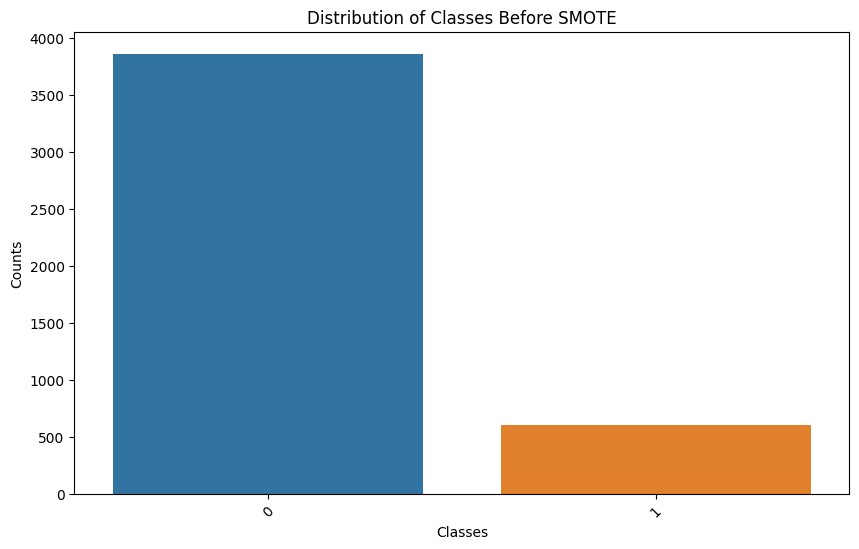

In [128]:
from collections import Counter

# Show distribution of data before SMOTE
y_train_counts = Counter(y_train)

# Plotting the distribution before SMOTE
plt.figure(figsize=(10, 6))
sns.barplot(x=list(y_train_counts.keys()), y=list(y_train_counts.values()))
plt.title('Distribution of Classes Before SMOTE')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.show()

In [129]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train, y_train = smote.fit_resample(X_train, y_train)



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


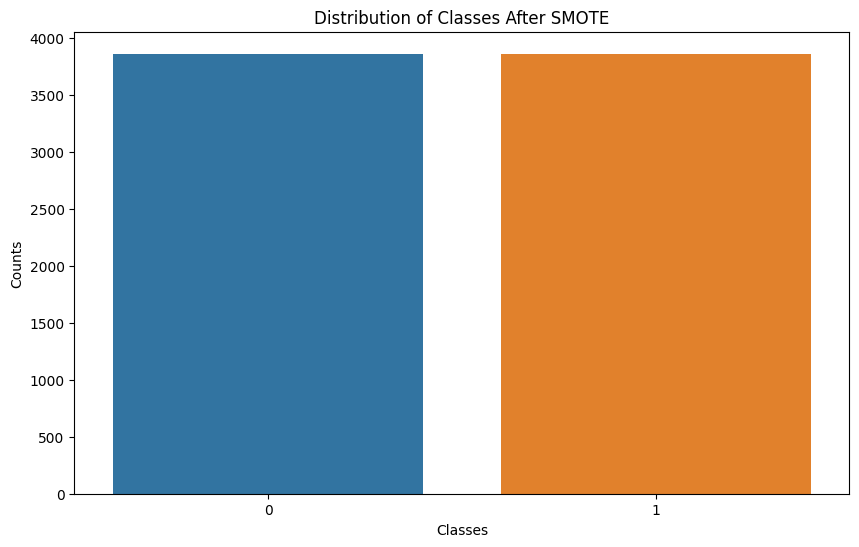

Distribution after SMOTE: Counter({0: 3860, 1: 3860})


In [130]:
# Show distribution after SMOTE
y_train_resampled_counts = Counter(y_train)

# Plotting the distribution after SMOTE
plt.figure(figsize=(10, 6))
sns.barplot(x=list(y_train_resampled_counts.keys()), y=list(y_train_resampled_counts.values()))
plt.title('Distribution of Classes After SMOTE')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()

print("Distribution after SMOTE:", y_train_resampled_counts)


In [131]:
# Create an SVM classifier with a linear kernel
svm_classifier = SVC(kernel='linear')

# Train the SVM classifier with TF-IDF vectorized data
svm_classifier.fit(X_train, y_train)

# Predict with the trained SVM classifier
y_pred_svc = svm_classifier.predict(X_test)

# Generate a classification report
target_names = ['ham (0)', 'spam(1)']  # 0: ham, 1: spam
report_svc = classification_report(y_test, y_pred_svc, target_names=target_names)
print('Classification Report:\n', report_svc)

Classification Report:
               precision    recall  f1-score   support

     ham (0)       0.98      0.99      0.99       965
     spam(1)       0.94      0.89      0.91       150

    accuracy                           0.98      1115
   macro avg       0.96      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115



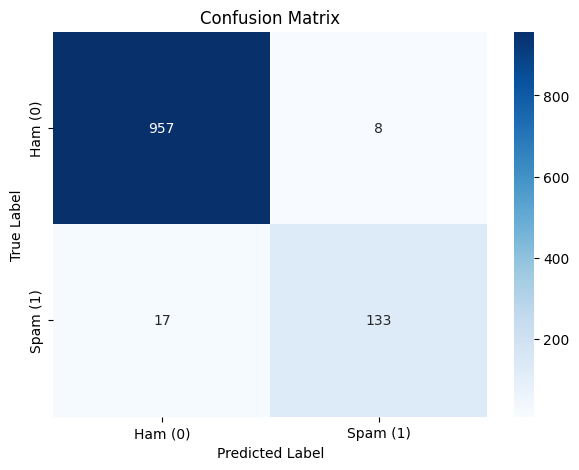

In [132]:
# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_svc)

plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham (0)', 'Spam (1)'],
            yticklabels=['Ham (0)', 'Spam (1)'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [133]:
# Create an NB classifier
nb_classifier = MultinomialNB()

# Train the NB classifier with TF-IDF vectorized data
nb_classifier.fit(X_train, y_train)

# Predict with the trained NB classifier
y_pred_nb = nb_classifier.predict(X_test)

# Generate a classification report
target_names = ['ham (0)', 'spam(1)']
report_nb = classification_report(y_test, y_pred_nb,target_names=target_names)
print('Classification Report:\n', report_nb)

Classification Report:
               precision    recall  f1-score   support

     ham (0)       0.98      0.98      0.98       965
     spam(1)       0.85      0.90      0.88       150

    accuracy                           0.97      1115
   macro avg       0.92      0.94      0.93      1115
weighted avg       0.97      0.97      0.97      1115



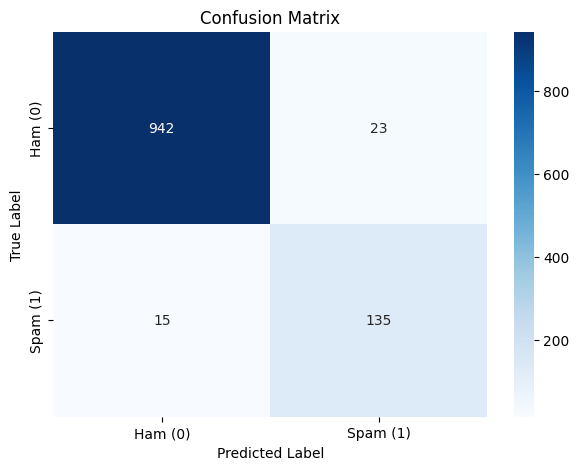

In [134]:
# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham (0)', 'Spam (1)'],
            yticklabels=['Ham (0)', 'Spam (1)'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [135]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Create the Decision Tree model
dt_classifier = DecisionTreeClassifier()

# Fit the model to the training data
dt_classifier.fit(X_train, y_train)

# Predict with the trained Decision Tree classifier
y_pred_dt = dt_classifier.predict(X_test)

# Generate a classification report
target_names = ['ham (0)', 'spam (1)']
report_dt = classification_report(y_test, y_pred_dt, target_names=target_names)

# Print the classification report
print('Classification Report:\n', report_dt)


Classification Report:
               precision    recall  f1-score   support

     ham (0)       0.98      0.97      0.97       965
    spam (1)       0.82      0.86      0.84       150

    accuracy                           0.96      1115
   macro avg       0.90      0.91      0.91      1115
weighted avg       0.96      0.96      0.96      1115



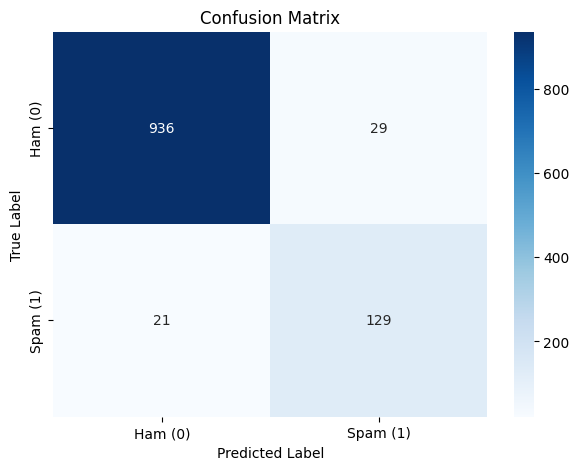

In [136]:
# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham (0)', 'Spam (1)'],
            yticklabels=['Ham (0)', 'Spam (1)'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

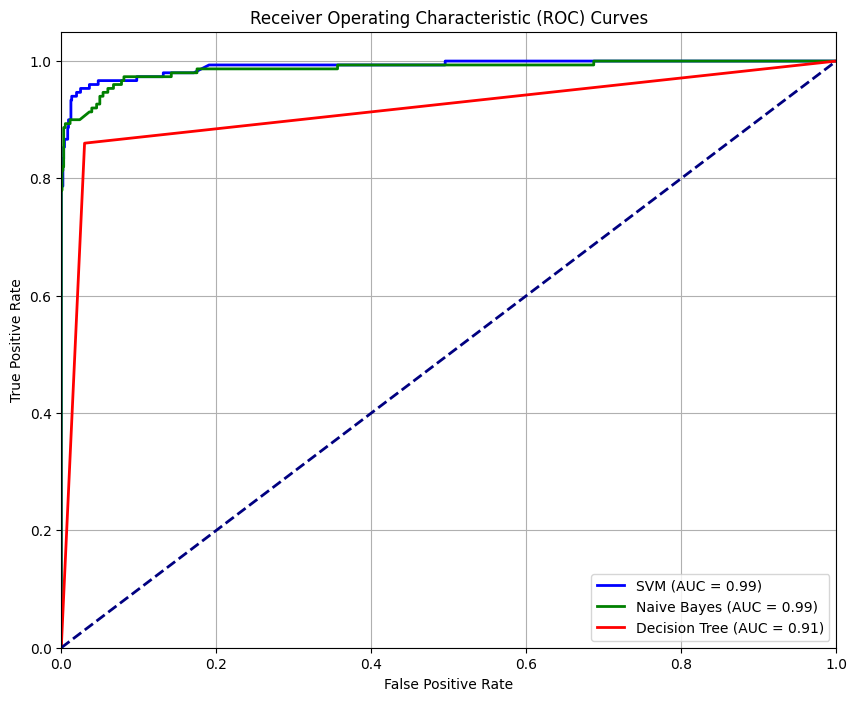

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Predictions from classifiers
y_pred_svc = svm_classifier.predict(X_test)
y_pred_nb = nb_classifier.predict(X_test)
y_pred_dt = dt_classifier.predict(X_test)

# For ROC curve, you typically need the predicted probabilities rather than class predictions.
# So, use decision_function for SVM and predict_proba for the others.
y_scores_svc = svm_classifier.decision_function(X_test)  # SVM
y_scores_nb = nb_classifier.predict_proba(X_test)[:, 1]  # Naive Bayes
y_scores_dt = dt_classifier.predict_proba(X_test)[:, 1]  # Decision Tree

# Calculate ROC curve and AUC
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_scores_svc)
roc_auc_svc = auc(fpr_svc, tpr_svc)

fpr_nb, tpr_nb, _ = roc_curve(y_test, y_scores_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_scores_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Plotting
plt.figure(figsize=(10, 8))
plt.plot(fpr_svc, tpr_svc, color='blue', lw=2, label='SVM (AUC = {:.2f})'.format(roc_auc_svc))
plt.plot(fpr_nb, tpr_nb, color='green', lw=2, label='Naive Bayes (AUC = {:.2f})'.format(roc_auc_nb))
plt.plot(fpr_dt, tpr_dt, color='red', lw=2, label='Decision Tree (AUC = {:.2f})'.format(roc_auc_dt))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [138]:
from sklearn.model_selection import cross_val_score

# Cross-validation for SVM classifier
cv_score_svm = cross_val_score(svm_classifier, X_train, y_train, cv=5, scoring='f1')
#print("SVM Classifier F1 scores:", cv_score_svm)
print(f"SVM Classifier Mean F1 Score: {cv_score_svm.mean():.2f}")

# Cross-validation for 
classifier
cv_score_nb = cross_val_score(nb_classifier, X_train, y_train, cv=5, scoring='f1')
#print("Naive Bayes Classifier F1 scores:", cv_score_nb)
print(f"Naive Bayes Classifier Mean F1 Score: {cv_score_nb.mean():.2f}")

# Cross-validation for Decision Tree classifier
cv_score_dt = cross_val_score(dt_classifier, X_train, y_train, cv=5, scoring='f1')
#print("Decision Tree Classifier F1 scores:", cv_score_dt)
print(f"Decision Tree Classifier Mean F1 Score: {cv_score_dt.mean():.2f}")


SVM Classifier Mean F1 Score: 1.00
Naive Bayes Classifier Mean F1 Score: 0.98
Decision Tree Classifier Mean F1 Score: 0.97
